# Clean and Trn/Val/Test Split Data
We want nice clean data to train on. This means we need to:
- remove bad data from both inputs and targets;
- interpolate targets where data is missing;
- split sensibly into trn/val/test sets that minimise temporal bias (towards certain years, for example), but also minimise information leakage from overlapping sample and target data

In [1]:
import pandas as pd

In [77]:
import os, glob
import numpy as np

In [11]:
import matplotlib.pyplot as plt

In [13]:
import random
r = lambda: random.randint(0,255)

In [162]:
from datetime import datetime as dt
from datetime import timedelta
from random import shuffle
import pickle

In [4]:
root = os.getcwd()

In [50]:
fs = glob.glob(os.path.join(root,'*_w_forecast.csv'))

In [130]:
dfs = {os.path.splitext(os.path.split(f)[1])[0].split('_')[0]:pd.read_csv(f).set_index('Unnamed: 0') for f in fs}

### Step 1: Remove bad data

In [131]:
color_dict = {kk:f'#{r():02x}{r():02x}{r():02x}' for kk in dfs.keys()}

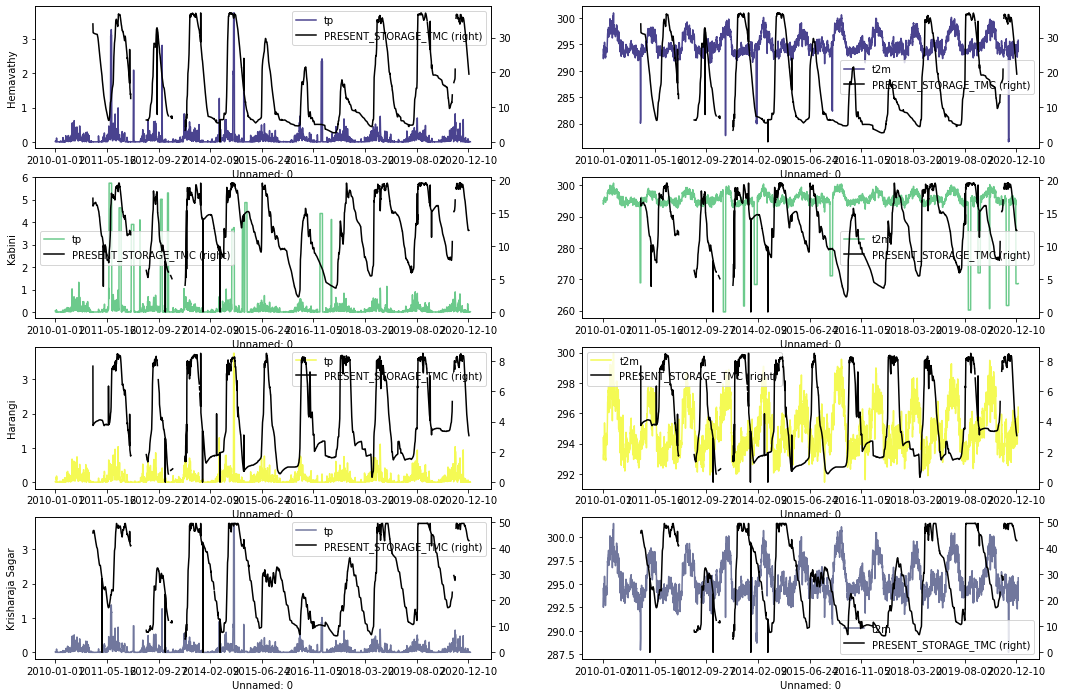

In [132]:
# visualise
fig, axs = plt.subplots(4,2, figsize=(18,12))
for ii_k, (kk, df) in enumerate(dfs.items()):
    df[['tp']].plot(ax=axs[ii_k][0], color=color_dict[kk])
    df[['PRESENT_STORAGE_TMC']].plot(ax=axs[ii_k][0], secondary_y='PRESENT_STORAGE_TMC', color='k')
    df[['t2m']].plot(ax=axs[ii_k][1], color=color_dict[kk])
    df[['PRESENT_STORAGE_TMC']].plot(ax=axs[ii_k][1], secondary_y='PRESENT_STORAGE_TMC', color='k')
    axs[ii_k][0].set_ylabel(kk)
plt.show()

Remove duplicates date data.

In [135]:
# show duplicates
for kk, df in dfs.items():
    print (kk, set(df[df.groupby('Unnamed: 0').size().sort_values()>1].index.values))

# only '2019-12-11' is actually bad data in all 4 reservoirs, the others are just duplicated

Hemavathy set()
Kabini set()
Harangi set()
Krisharaja Sagar set()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:
# Having checked the data, and for each reservoir, the correct data is the **second** entry.
for kk in dfs.keys():
    dfs[kk] = dfs[kk].groupby('Unnamed: 0').nth(-1)

Set remaining bad data to NaN so it can be interpolated

In [136]:
# data was inspected by hand for bad dates
bad_data_dates = {
    'Hemavathy':[
        '2010-09-30',
        '2011-12-22',
        '2012-09-14',
        '2013-11-09',
        '2014-05-15',
        '2015-01-01',
    ], 
    'Kabini':[
        '2010-09-30',
        '2011-04-11',
        '2012-12-01',
        '2013-11-09',
        '2013-12-01',
        '2014-05-15',
        '2019-12-22',
        '2019-12-23'
    ], 
    'Harangi':[
        '2010-09-30',
        '2010-12-31',
        '2011-05-31',
        '2011-12-22',
        '2012-12-01',
        '2013-06-26',
        '2013-11-09',
        '2013-11-27',
        '2014-04-12',
        '2014-05-15',
        '2015-01-01',
    ], 
    'Krisharaja Sagar':[
        '2010-09-30',
        '2011-03-29',
        '2012-12-01',
        '2013-12-01',
        '2014-05-15'
    ]
}

In [139]:
for kk in dfs.keys():
    dfs[kk].loc[:,'FLAG_BAD_DATA'] = 0
    dfs[kk].loc[bad_data_dates[kk],'FLAG_BAD_DATA'] = 1
    dfs[kk].loc[bad_data_dates[kk],['PRESENT_STORAGE_TMC','RES_LEVEL_FT']] = np.ones(dfs[kk].loc[bad_data_dates[kk],['PRESENT_STORAGE_TMC','RES_LEVEL_FT']].shape) * np.nan

Clip ERA5 outliers: temp>=290; tp<=2; add flags for future

In [144]:
for kk in dfs.keys():
    dfs[kk].loc[:,'FLAG_t2m'] = 0
    dfs[kk].loc[dfs[kk]['t2m']<290,'FLAG_t2m'] = 1
    dfs[kk].loc[dfs[kk]['t2m']<290,'t2m'] = np.nan
    dfs[kk].loc[:,'FLAG_tp'] = 0
    dfs[kk].loc[dfs[kk]['tp']>2,'FLAG_tp'] = 1
    dfs[kk].loc[dfs[kk]['tp']>2,'tp'] = np.nan

Now interpolate the data back in

In [147]:
for kk in dfs.keys():
    dfs[kk].loc[:,['t2m','tp','PRESENT_STORAGE_TMC','RES_LEVEL_FT']] = dfs[kk].loc[:,['t2m','tp','PRESENT_STORAGE_TMC','RES_LEVEL_FT']].interpolate(limit_direction='both',limit_area='inside',axis=0)

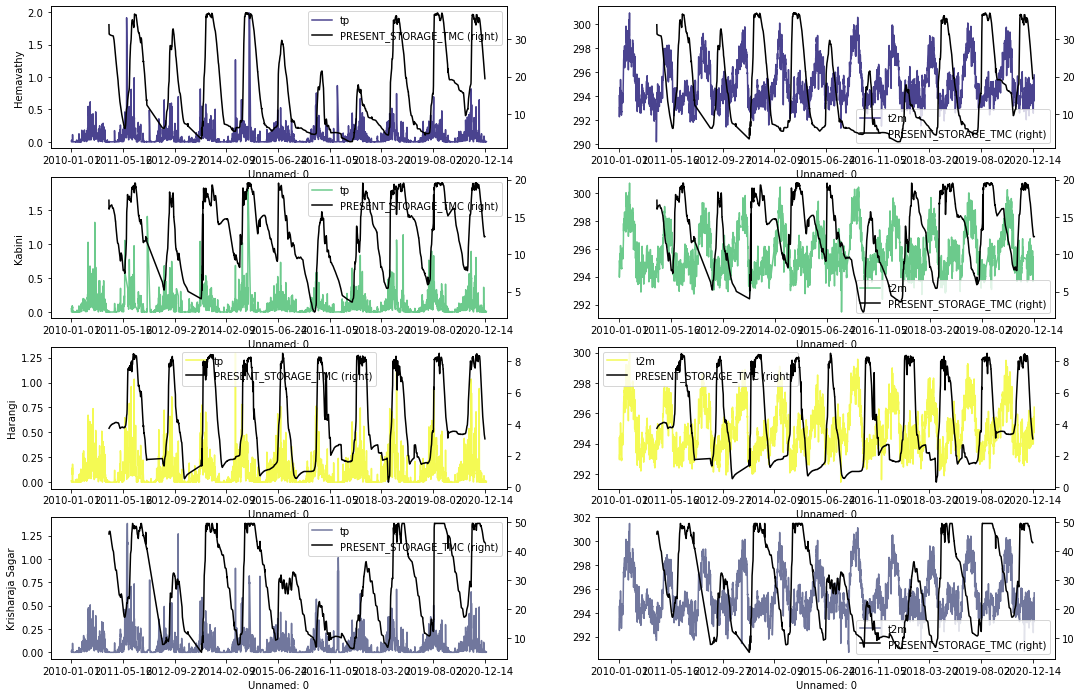

In [149]:
# visualise
fig, axs = plt.subplots(4,2, figsize=(18,12))
for ii_k, (kk, df) in enumerate(dfs.items()):
    df[['tp']].plot(ax=axs[ii_k][0], color=color_dict[kk])
    df[['PRESENT_STORAGE_TMC']].plot(ax=axs[ii_k][0], secondary_y='PRESENT_STORAGE_TMC', color='k')
    df[['t2m']].plot(ax=axs[ii_k][1], color=color_dict[kk])
    df[['PRESENT_STORAGE_TMC']].plot(ax=axs[ii_k][1], secondary_y='PRESENT_STORAGE_TMC', color='k')
    axs[ii_k][0].set_ylabel(kk)
plt.show()

### Now get trn/val/test splits

Check start and end times

In [156]:
for kk, df in dfs.items():
    df.index = pd.to_datetime(df.index)
    sdate = df.loc[~df['PRESENT_STORAGE_TMC'].isna()].index.min()
    edate = df.loc[~df['PRESENT_STORAGE_TMC'].isna()].index.max()
    print (sdate, edate, (edate-sdate).days)

2010-12-31 00:00:00 2020-12-16 00:00:00 3638
2010-12-31 00:00:00 2020-12-16 00:00:00 3638
2011-01-01 00:00:00 2020-12-16 00:00:00 3637
2010-12-31 00:00:00 2020-12-16 00:00:00 3638


We have ~120 months of data. Let's use 18 months each in 6 groups of 3 for validation and test. Or maybe 9 groups of 3 for each?

In [211]:
chosen_months = []
remaining_months = list(range(119-2))
# select 9+9 start months randomly
for ii in range(18):
    chosen_month = np.random.choice(remaining_months)
    chosen_months.append(chosen_month)
    remaining_months = [m for m in remaining_months if m not in range(chosen_month, chosen_month+3)]
    print(chosen_month, len(remaining_months))

42 114
14 111
102 108
31 105
60 102
81 99
53 96
110 93
20 90
67 87
45 84
36 81
6 78
25 75
77 72
86 69
49 66
76 65


In [212]:
valtest_ranges = [
    pd.date_range(
        dt(year=2011+m//12, month=m%12+1, day=1),
        periods=2, 
        freq='MS'
    ) for m in chosen_months
]

In [213]:
shuffle(valtest_ranges)

In [218]:
pickle.dump(valtest_ranges, open(os.path.join(root,'18x2mo_valtest.pkl'),'wb'))

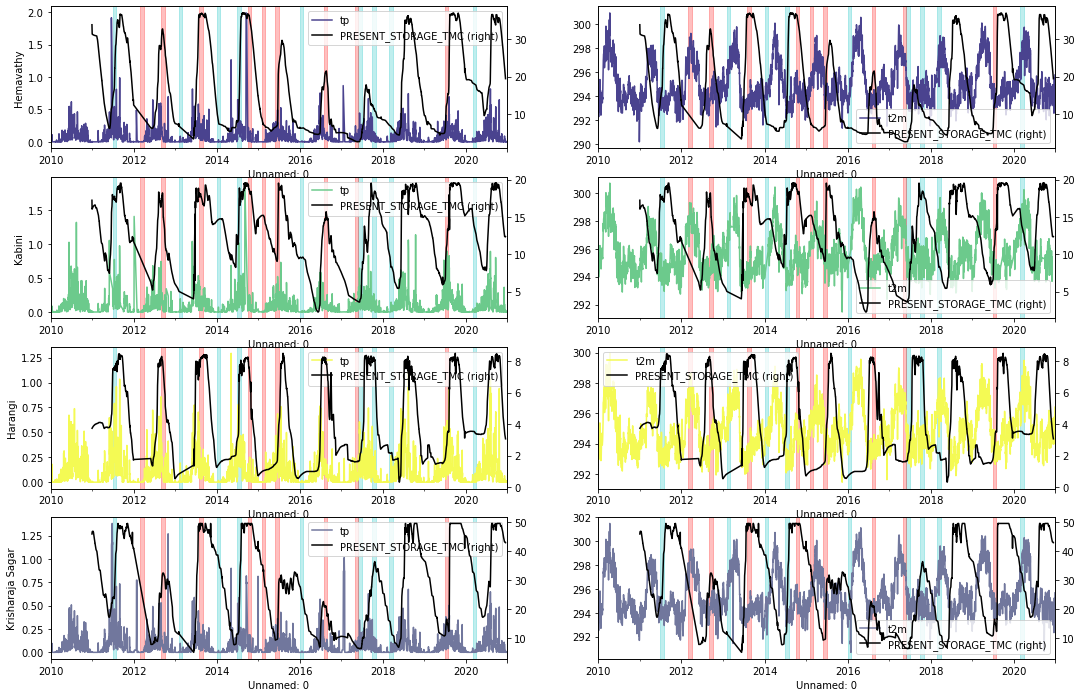

In [214]:
fig, axs = plt.subplots(4,2, figsize=(18,12))
for ii_k, (kk, df) in enumerate(dfs.items()):
    df[['tp']].plot(ax=axs[ii_k][0], color=color_dict[kk])
    df[['PRESENT_STORAGE_TMC']].plot(ax=axs[ii_k][0], secondary_y='PRESENT_STORAGE_TMC', color='k')
    df[['t2m']].plot(ax=axs[ii_k][1], color=color_dict[kk])
    df[['PRESENT_STORAGE_TMC']].plot(ax=axs[ii_k][1], secondary_y='PRESENT_STORAGE_TMC', color='k')
    axs[ii_k][0].set_ylabel(kk)
    
    for drange, segment in zip(valtest_ranges,['val']*9+['test']*9):
        for ii in range(2):
            if segment=='val':
                c='c'
            else:
                c='r'
            axs[ii_k][ii].axvspan(drange.min(), drange.max(), color=c, alpha=0.25)

plt.show()

In [215]:
for kk in dfs.keys():
    dfs[kk].loc[:,'segment'] = 'trn'
    for drange, segment in zip(valtest_ranges,['val']*9+['test']*9):
        dfs[kk].loc[(dfs[kk].index>=drange.min()) & (dfs[kk].index<drange.max()),'segment'] = segment

In [216]:
for kk in dfs.keys():
    print (kk, dfs[kk].groupby('segment').size())

Hemavathy segment
test     274
trn     3468
val      275
dtype: int64
Kabini segment
test     274
trn     3468
val      275
dtype: int64
Harangi segment
test     274
trn     3468
val      275
dtype: int64
Krisharaja Sagar segment
test     274
trn     3468
val      275
dtype: int64


In [217]:
for kk, df in dfs.items():
    df.to_csv(os.path.join(root,'wave2web_data',f'{kk}_18x2mo_split.csv'))